# Clustering

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
import config as general_paths
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

In [3]:
adata_path = os.path.join(input_path,'campari_from_kallisto.h5ad')
adata_all_path = os.path.join(input_path,'campari_raw_all_genes_from_kallisto.h5ad')

campari_umap_file = 'campari_scs_umap_from_kallisto.h5ad'

matlab_matrix_file_name =  'kallisto_plates_till_7_from_ilona_'


NO_PCA = 20 # maybe 20...

In [4]:
adata = ad.read_h5ad(adata_path)
adata_all = ad.read_h5ad(adata_all_path)

In [5]:
adata

AnnData object with n_obs × n_vars = 2126 × 16000
    obs: 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

# Principal Component Analysis

In [6]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


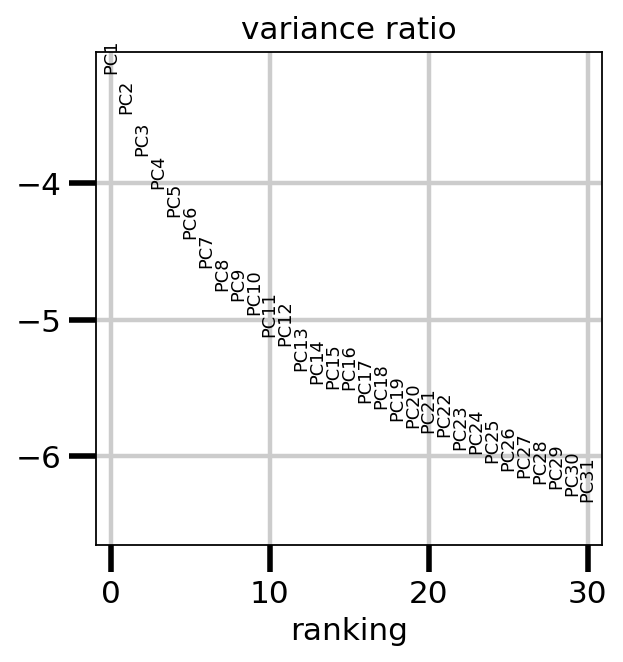

In [7]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function
sc.pl.pca_variance_ratio(adata, log=True)

# Computing the neighborhood graph

In [8]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata, n_pcs=NO_PCA)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [9]:
# We suggest embedding the graph in two dimensions using UMAP 
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


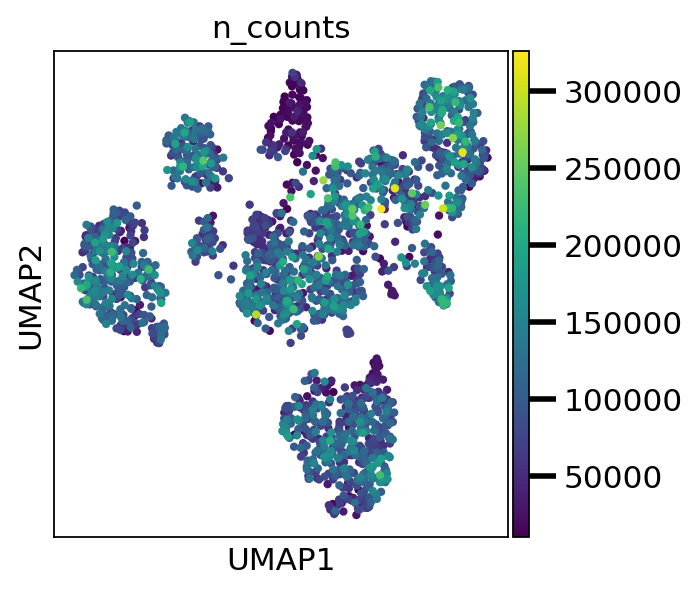

In [10]:
# You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw
sc.pl.umap(adata, color='n_counts', use_raw=False)

In [11]:
# Perform clustering - using highly variable genes
louvain_paramenters = [0.5,1,1.5,2,2.5]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata, resolution=value, key_added=name)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain_r2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain_r2.5', the cluster labels (adata.obs, categorical) (0:00:00)


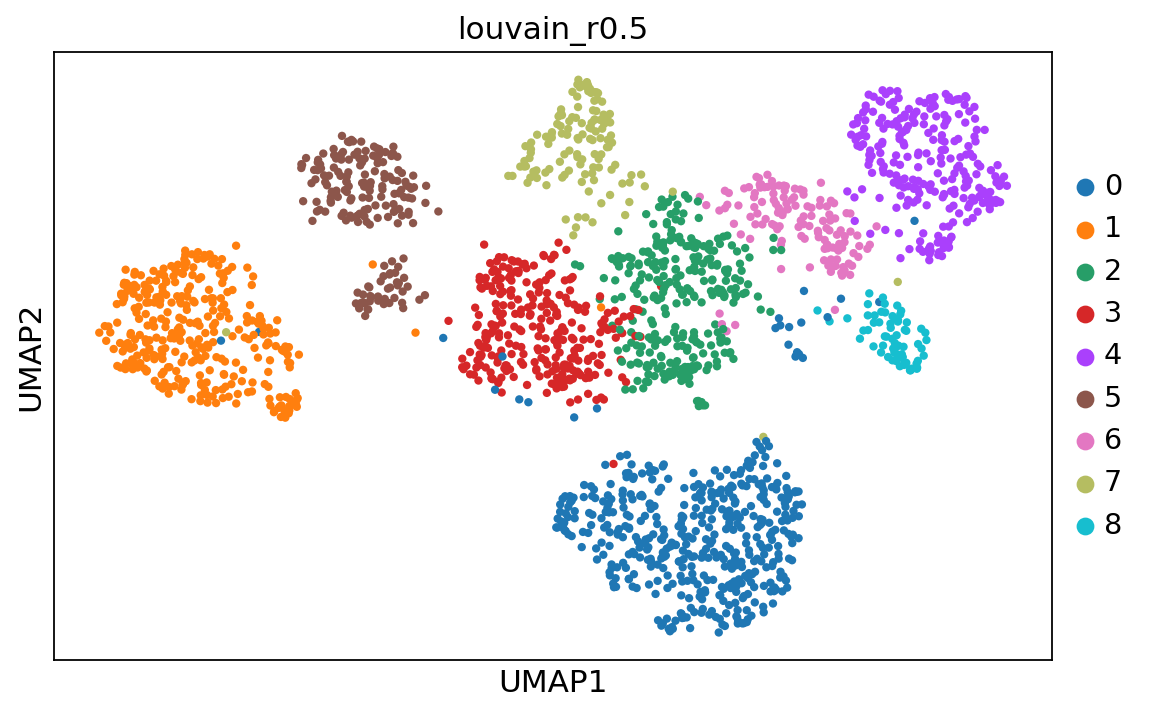

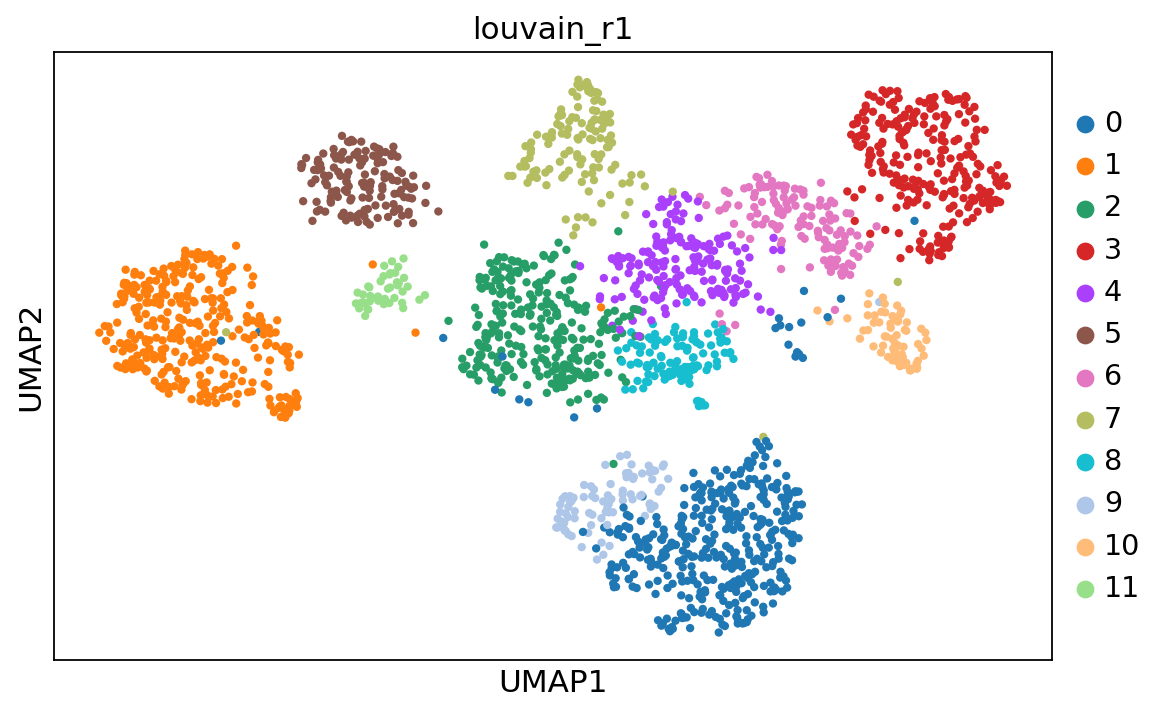

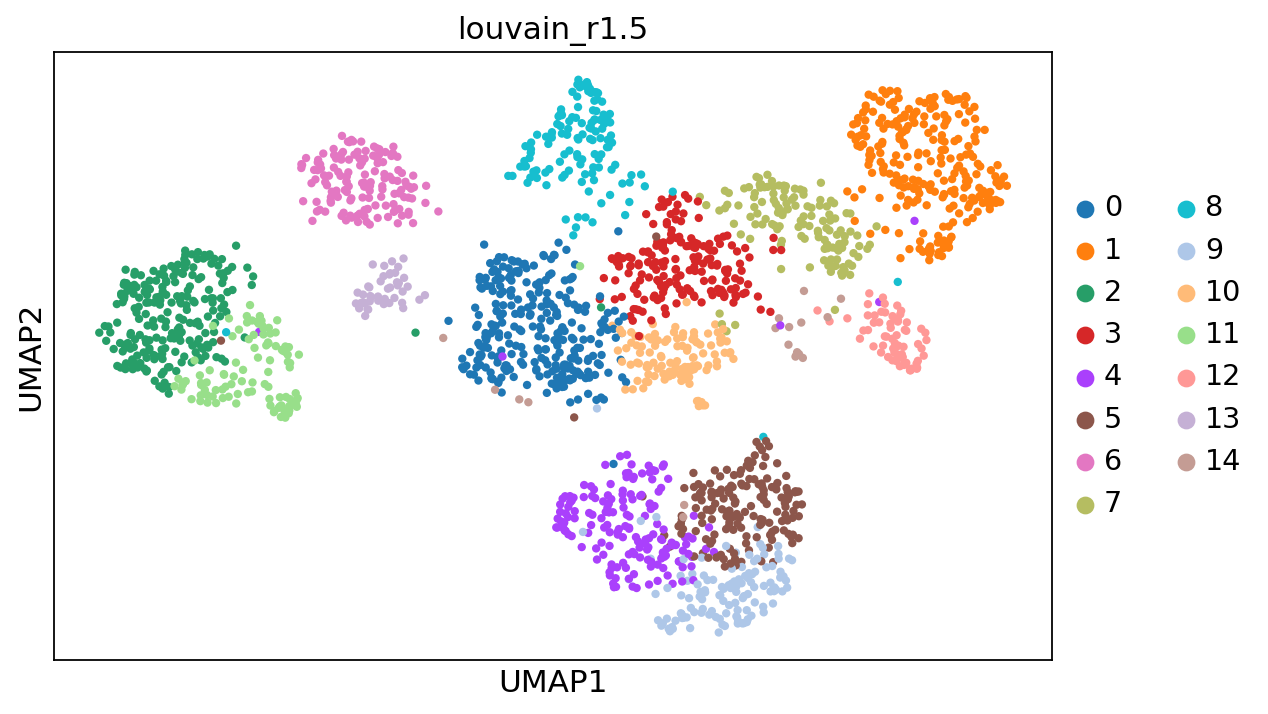

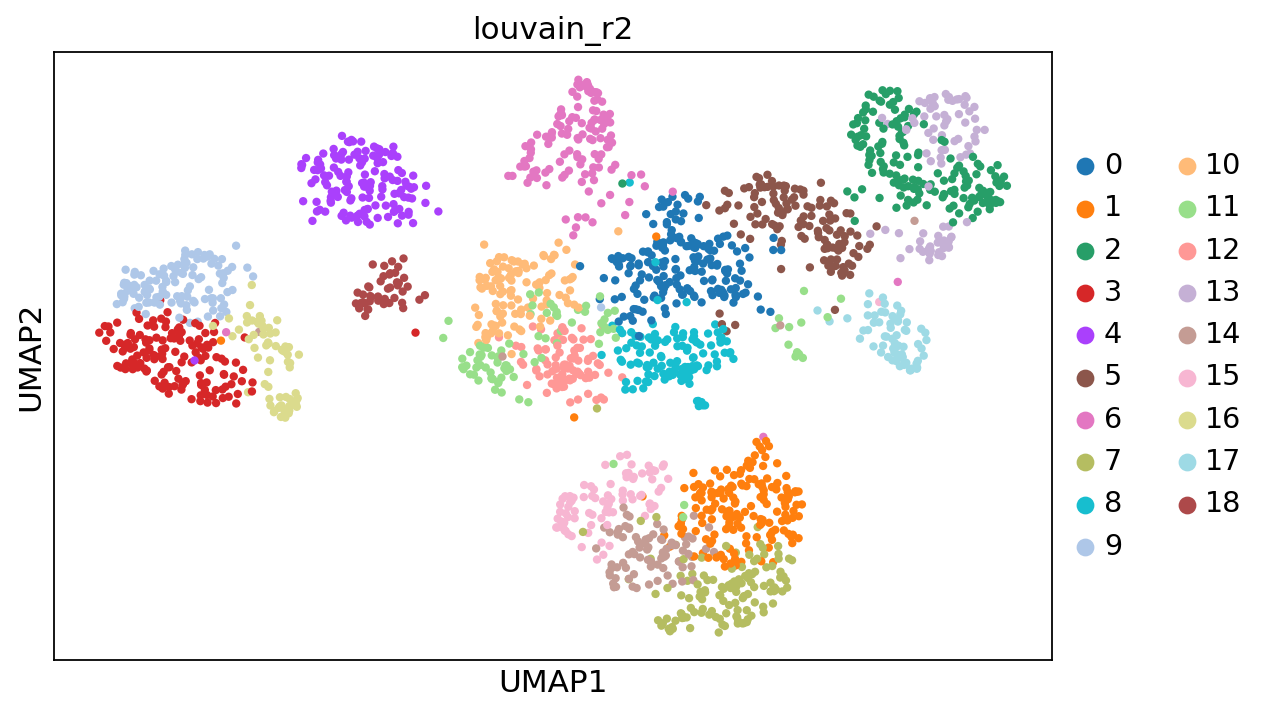

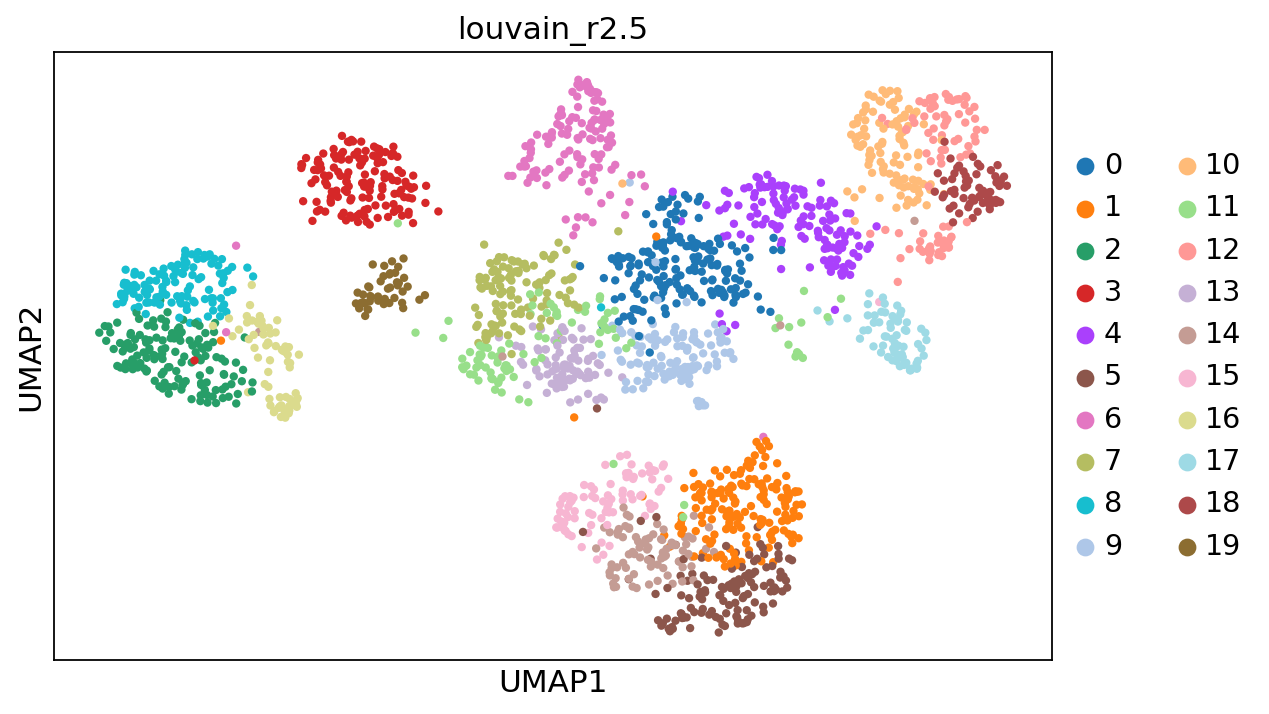

In [12]:
rcParams['figure.figsize']=(8,5)

# Visualize the clustering and how this is reflected by different technical covariates
for name in louvain_names:
    sc.pl.umap(adata, color=[name], use_raw=False, save = '_'+name + '.png')
    # sc.pl.umap(adata, color=[name,'n_counts'], use_raw=False, save = '_'+name + '.png')

In [13]:
# save umap data
adata.write_h5ad(
    os.path.join(input_path, campari_umap_file)
)

In [14]:
# chnange plate numbers to strings and categorical
plate_str = [str(int(el)) for el in list(adata.obs["plate_number"])]

In [15]:
adata.obs['plate_str']=plate_str
adata.obs['plate_str'].astype('category') 

barcode
TCCGATAACTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TCCGATAACTCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TTCACCACGGCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TTCACCACGGCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
TTCACCAGCTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    1
                                                                                      ..
CGGTAACGGTGAGCGGAACT-sample7                                                           7
GACTAGGTCCACCTCACCAG-sample7                                                           7
TCACCACATAACCTCACCAG-sample7                                                           7
AGCTCCACTGCGGTTGGCTA-sample7                                                           7
CGGTTGAACGGAGCGGAACT-sample7                                                           7
Name: plate_s

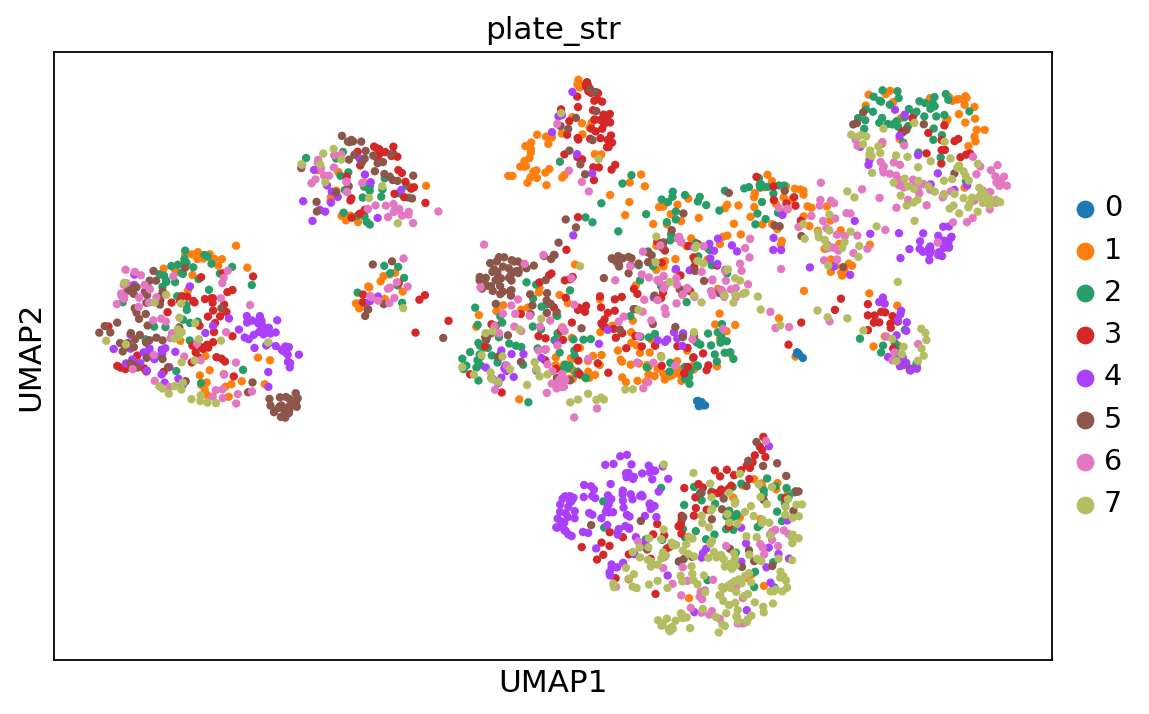

In [16]:
# check for batch effect
sc.pl.umap(adata, color ="plate_str")